# Exploring simplification with [`cityseer`](https://github.com/benchmark-urbanism/cityseer-api)

* **Simons, G.** (2023). *The cityseer Python package for pedestrian-scale network-based urban analysis*. Environment and Planning B: Urban Analytics and City Science, 50(5), 1328-1344. https://doi.org/10.1177/23998083221133827

-----------------

1. Environment & setup
2. Adjusted demo from [`graph_cleaning.ipynb`](https://github.com/benchmark-urbanism/cityseer-examples/blob/main/notebooks/graph_cleaning.ipynb)
   1. AOI: Barcelona
   2. Raw & simplified graphs
   3. Plots
3. Preliminary Evaluation

-----------------

## 1. Environment & setup

### Create `mamba` environment with `cityseer`'s dependencies & several options:

* [`pyproject.dependencies`](https://github.com/benchmark-urbanism/cityseer-api/blob/f17df2f3468332619fd4640f0c826a4582792ce5/pyproject.toml#L37)
```
    "matplotlib>=3.5.1"
    "networkx>=2.8.8"
    "pyproj>=3.3.0"
    "requests>=2.27.1"
    "scikit-learn>=1.0.2"
    "tqdm>=4.63.1"
    "shapely>=2.0.2"
    "numpy>=1.23.3"
    "geopandas>=0.12.2"
    "rasterio>=1.3.9"
```
* [`pyproject.[tool.pdm.dev-dependencies]`](https://github.com/benchmark-urbanism/cityseer-api/blob/master/pyproject.toml#L84)
```
    "osmnx>=1.3.0"
    "momepy>=0.5.4"
```

### Environment creation commands

```
$ mamba create -n py311_cityseer \
    python=3.11 \
    pip \
    jupyterlab \
    matplotlib \
    networkx \
    pyproj \
    requests \
    scikit-learn \
    tqdm \
    shapely \
    numpy \
    geopandas \
    rasterio \
    osmnx \
    momepy \
    # for notebooks, etc.
    utm \
    watermark 
$ pip install cityseer
```

-----------------------------

In [1]:
%load_ext watermark
%watermark

Last updated: 2024-01-21T20:45:51.610964-05:00

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.20.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
import cityseer
import shapely
import utm

from cityseer.tools import graphs, plot, io

%watermark -w
%watermark -iv

Watermark: 2.4.3

shapely : 2.0.2
utm     : 0.7.0
cityseer: 4.9.0



-------------------------

## 2. Adjusted demo from [`graph_cleaning.ipynb`](https://github.com/benchmark-urbanism/cityseer-examples/blob/main/notebooks/graph_cleaning.ipynb)

### AOI – London Soho or Barcelona

In [3]:
# Let's download data within a 1,250m buffer around London Soho:
#lng, lat = -0.13396079424572427, 51.51371088849723
lng, lat = 2.166981, 41.389526 # -- Barcelona - which is a complex case

buffer = 1250

# creates a WGS shapely polygon
poly_wgs, _ = io.buffered_point_poly(lng, lat, buffer)

### Fetch networks

* use a WGS shapely polygon to download information from OSM (both)

#### Raw graph

* helper func for object info

In [4]:
def graph_size(info, g):    
    print(f"{info}\n\t* {g}")

In [5]:
G_raw = io.osm_graph_from_poly(poly_wgs, simplify=False)
G_raw

INFO:cityseer.tools.io:Converting networkX graph from EPSG code 4326 to EPSG code 32631.
INFO:cityseer.tools.io:Processing node x, y coordinates.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10570/10570 [00:00<00:00, 482140.61it/s]
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12318/12318 [00:00<00:00, 1170835.01it/s]
INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12318/12318 [00:00<00:00, 92841.46it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [6]:
graph_size("Raw – default params", G_raw)

Raw – default params
	* MultiGraph with 5569 nodes and 7317 edges


#### Simplfied graph

In [7]:
G_utm = io.osm_graph_from_poly(poly_wgs, simplify=True)
G_utm

INFO:cityseer.tools.io:Converting networkX graph from EPSG code 4326 to EPSG code 32631.
INFO:cityseer.tools.io:Processing node x, y coordinates.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10570/10570 [00:00<00:00, 531746.03it/s]
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12318/12318 [00:00<00:00, 1013087.51it/s]
INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12318/12318 [00:00<00:00, 51389.02it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [8]:
graph_size("Simplified – default params", G_utm)

Simplified – default params
	* MultiGraph with 989 nodes and 1570 edges


#### Plotting bounds

In [9]:
# select extents for clipping the plotting extents
easting, northing = utm.from_latlon(lat, lng)[:2]
buff = shapely.Point(easting, northing).buffer(1000)
min_x, min_y, max_x, max_y = buff.bounds

#### Reusable plot function

In [10]:
def simple_plot(_G, plot_geoms=True, figsize=(6, 6)):
    # plot using the selected extents
    plot.plot_nx(
        _G,
        labels=False,
        plot_geoms=plot_geoms,
        node_size=4,
        edge_width=1,
        x_lim=(min_x, max_x),
        y_lim=(min_y, max_y),
        figsize=figsize,
        dpi=150,
    )

### Raw graph

INFO:cityseer.tools.plot:Preparing graph nodes
INFO:cityseer.tools.plot:Preparing graph edges
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7317/7317 [00:00<00:00, 17052.03it/s]


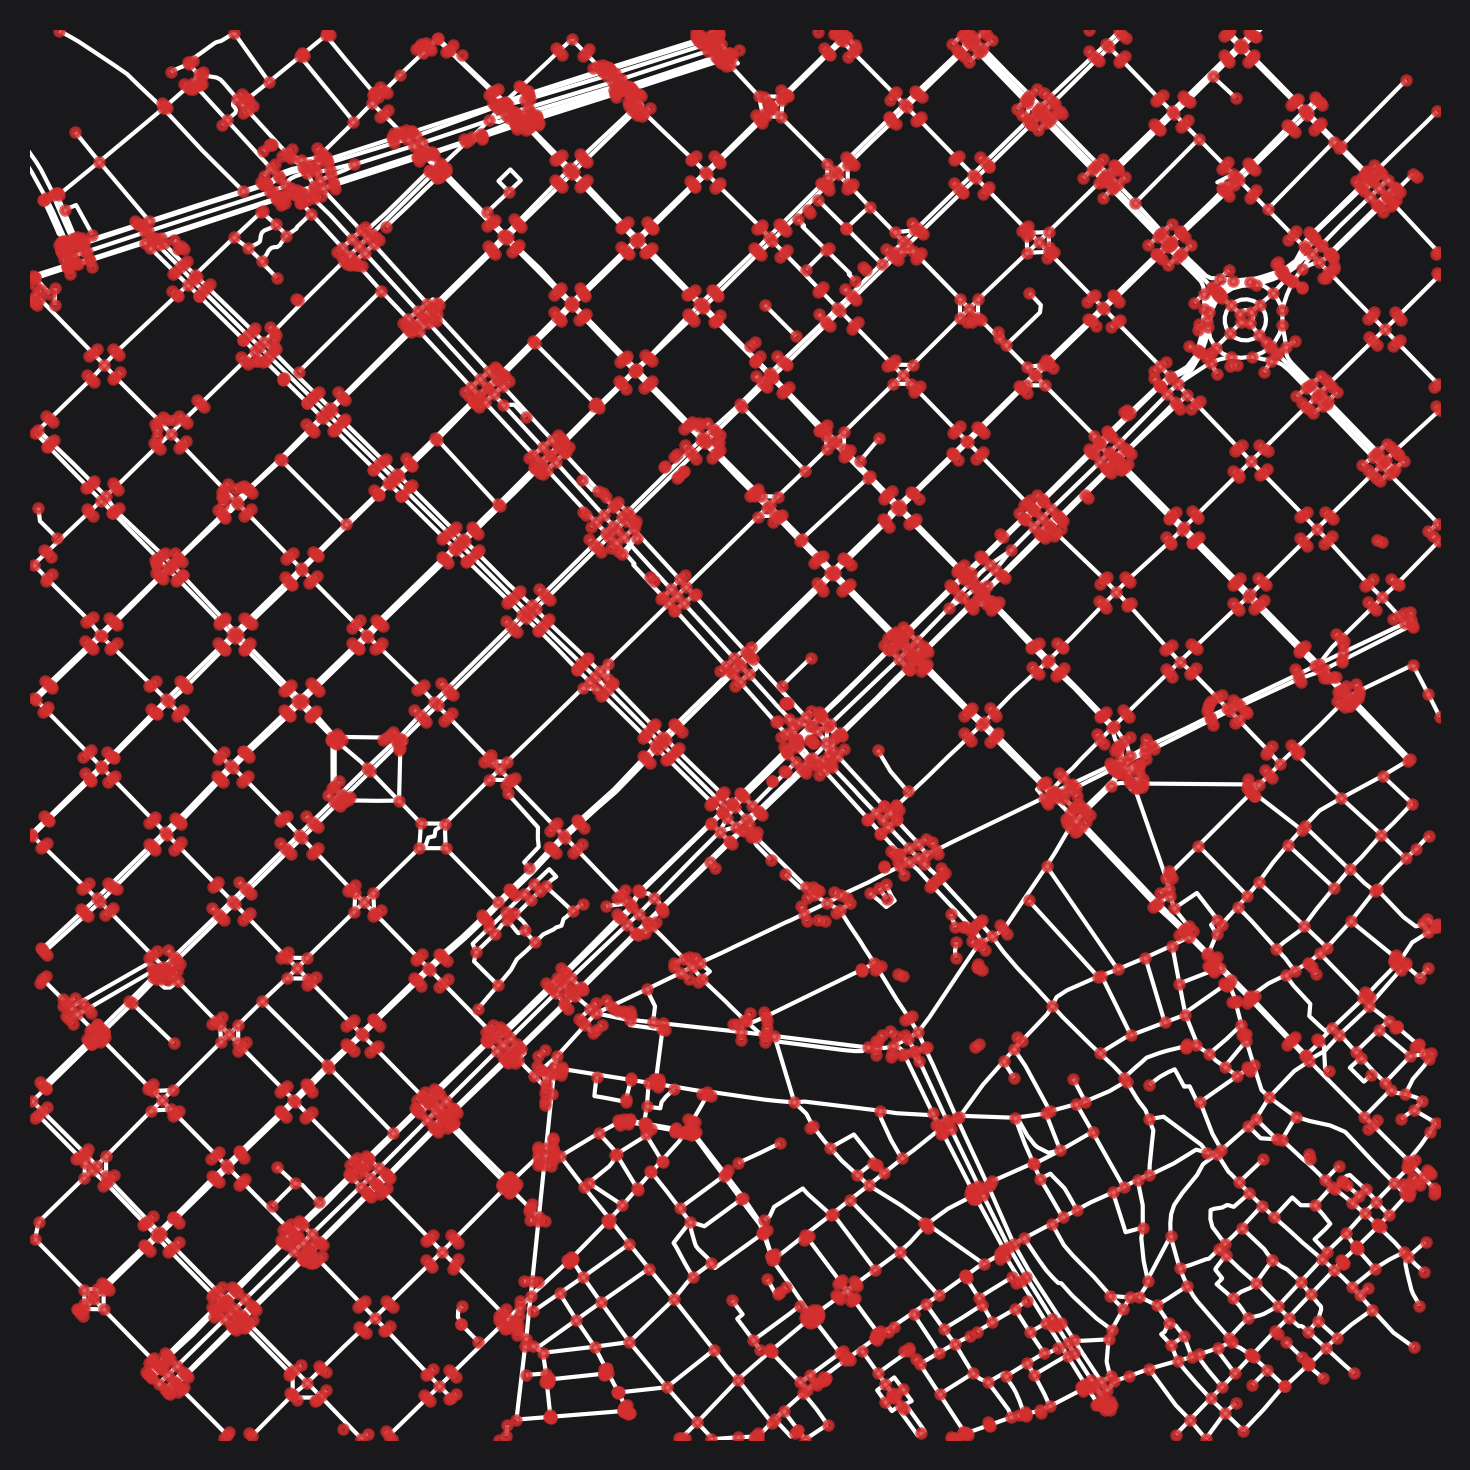

In [11]:
simple_plot(G_raw, plot_geoms=True, figsize=(5,5))

### Simplified (default params)

INFO:cityseer.tools.plot:Preparing graph nodes
INFO:cityseer.tools.plot:Preparing graph edges
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1570/1570 [00:00<00:00, 44519.80it/s]


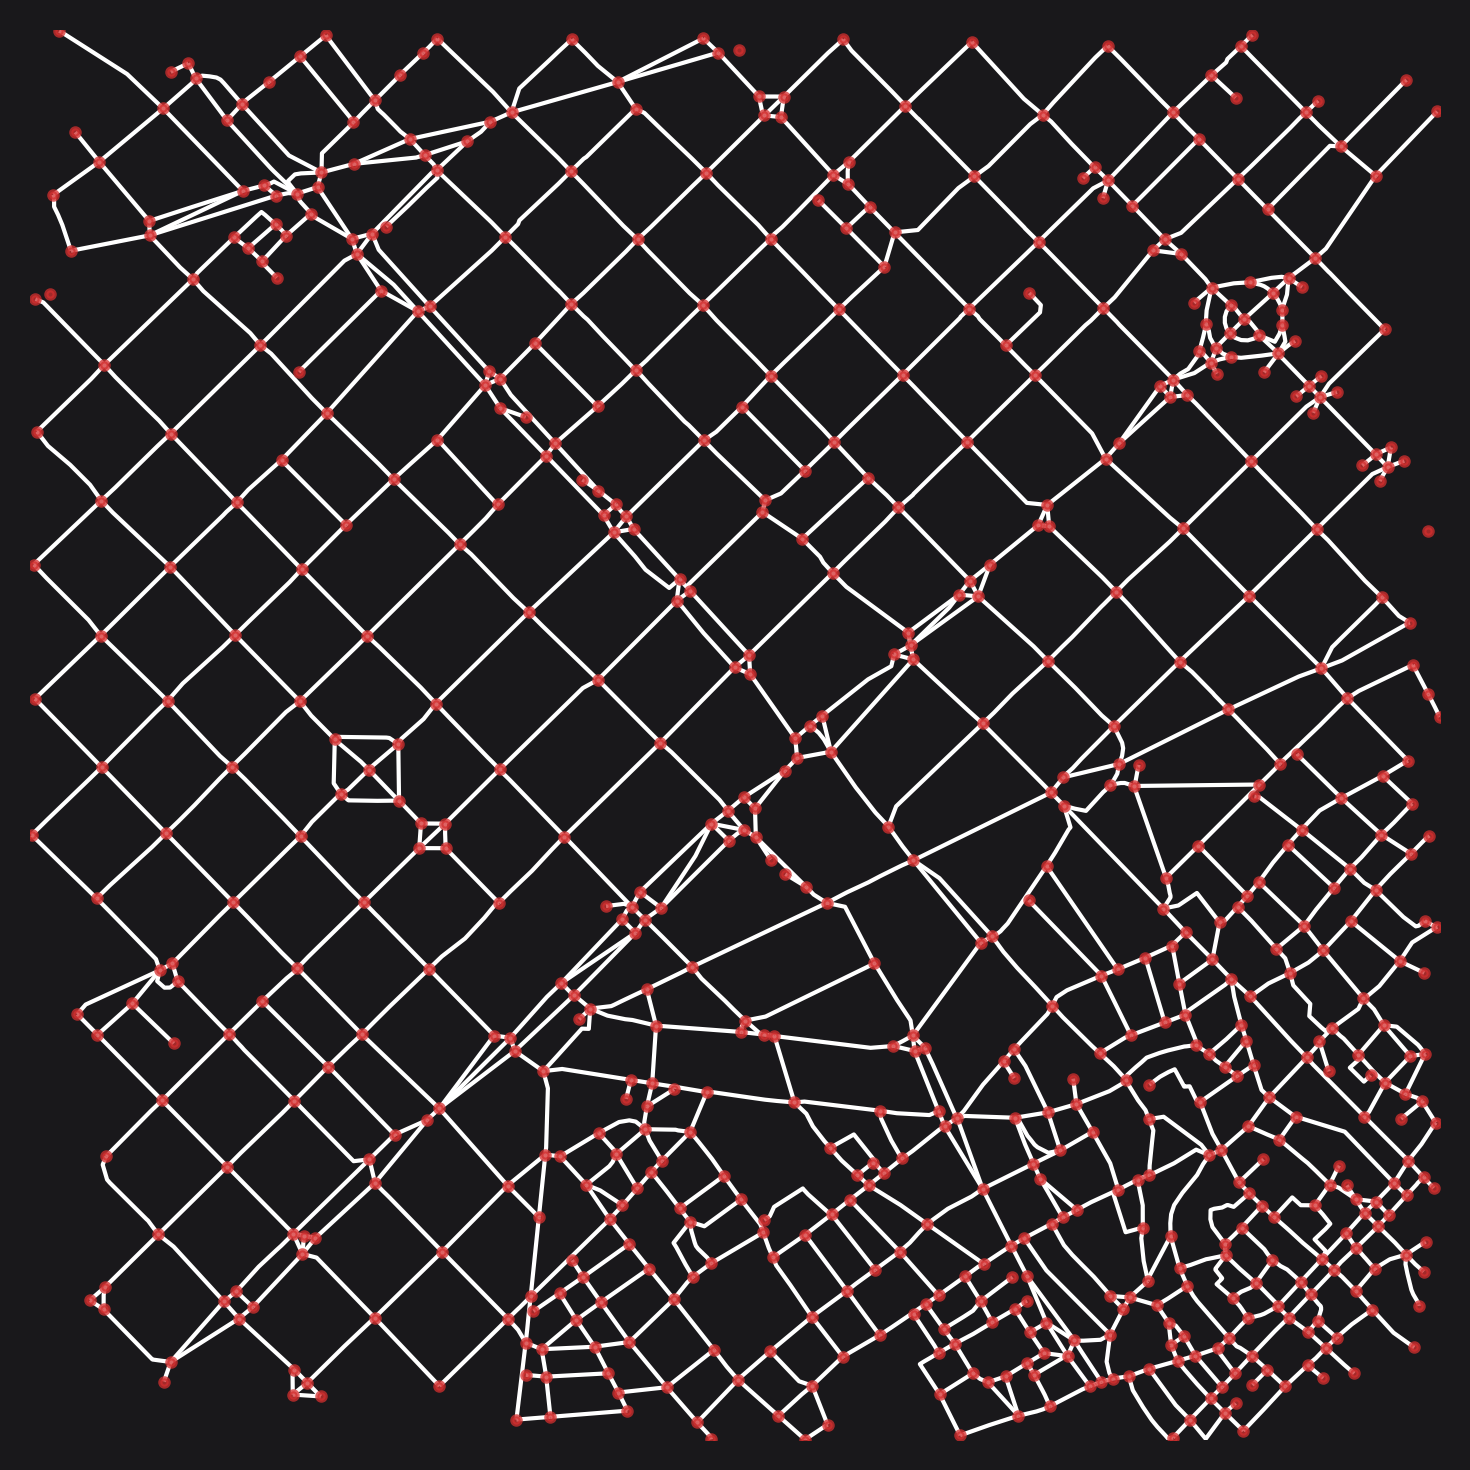

In [12]:
simple_plot(G_utm, plot_geoms=True, figsize=(5,5))

--------------------------

## Preliminary Evaluation

* `simplify` only available as a baked-in process within [`cityseer.tools.io.osm_graph_from_poly()`](https://github.com/benchmark-urbanism/cityseer-api/blob/f17df2f3468332619fd4640f0c826a4582792ce5/pysrc/cityseer/tools/io.py#L222), which is found [here](https://github.com/benchmark-urbanism/cityseer-api/blob/f17df2f3468332619fd4640f0c826a4582792ce5/pysrc/cityseer/tools/io.py#L357) consisting of the following workflow by function call:
    1.  [`graphs.nx_remove_dangling_nodes()`](https://github.com/benchmark-urbanism/cityseer-api/blob/f17df2f3468332619fd4640f0c826a4582792ce5/pysrc/cityseer/tools/graphs.py#L234)
    2.  [`graphs.nx_consolidate_nodes()`](https://github.com/benchmark-urbanism/cityseer-api/blob/f17df2f3468332619fd4640f0c826a4582792ce5/pysrc/cityseer/tools/graphs.py#L655)
        1. [`graphs.nx_remove_filler_nodes`](https://github.com/benchmark-urbanism/cityseer-api/blob/f17df2f3468332619fd4640f0c826a4582792ce5/pysrc/cityseer/tools/graphs.py#L85)
        1. [`graphs.nx_merge_parallel_edges()`](https://github.com/benchmark-urbanism/cityseer-api/blob/f17df2f3468332619fd4640f0c826a4582792ce5/pysrc/cityseer/tools/graphs.py#L304)
    3.   [`graphs.nx_split_opposing_geoms()`](https://github.com/benchmark-urbanism/cityseer-api/blob/f17df2f3468332619fd4640f0c826a4582792ce5/pysrc/cityseer/tools/graphs.py#L808)
         1.  `graphs.nx_merge_parallel_edges()`
    4.  `graphs.nx_consolidate_nodes()`
         1. `graphs.nx_remove_filler_nodes()` 
    5.  `graphs.nx_remove_filler_nodes()`
    6.  [`graphs.nx_iron_edges()`](https://github.com/benchmark-urbanism/cityseer-api/blob/f17df2f3468332619fd4640f0c826a4582792ce5/pysrc/cityseer/tools/graphs.py#L451)
         1.  `graphs.nx_merge_parallel_edges()`
    7.  `graphs.nx_split_opposing_geoms()`
         1.  `graphs.nx_merge_parallel_edges()`
    8.  `graphs.nx_consolidate_nodes()`
         1. `graphs.nx_remove_filler_nodes()` 
    9.  `graphs.nx_remove_filler_nodes()`
    10.  `graphs.nx_iron_edges()`
         1. `graphs.nx_merge_parallel_edges()`
* Perhaps better broken down into steps...?
* Will require ***a lot of*** playing with parameters, etc...
* Actually using `Rust`? Seems like in the [`metrics`](https://github.com/benchmark-urbanism/cityseer-api/tree/master/pysrc/cityseer/metrics) functionality, but not the [`tools`](https://github.com/benchmark-urbanism/cityseer-api/tree/master/pysrc/cityseer/tools) functionality?